In [10]:
%%bash
python evaluation_based_sampling.py

Test 1 passed
Test 2 passed
Test 3 passed
Test 4 passed
Test 5 passed
Test 6 passed
Test 7 passed
Test 8 passed
Test 9 passed
Test 10 passed
Test 11 passed
Test 12 passed
Test 13 passed
All 13 deterministic tests passed
('normal', 5, 1.4142136)
p value 0.8007084502688623
('beta', 2.0, 5.0)
p value 0.570232967759639
('exponential', 0.0, 5.0)
p value 0.11315320065439927
('normal', 5.3, 3.2)
p value 0.9547243874435392
('normalmix', 0.1, -1, 0.3, 0.9, 1, 0.3)
p value 0.7550768772041979
('normal', 0, 1.44)
p value 0.6280392825189822
All probabilistic tests passed



Sample of prior of program 1:
tensor(3.8318)



Sample of prior of program 2:
tensor([-11.5714,  -6.0625])



Sample of prior of program 3:
tensor([2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2.])



Sample of prior of program 4:
[[[-1.7676916122436523], [-1.118196725845337], [-0.9354032278060913], [0.4580332338809967], [1.044437289237976], [-0.4065367579460144], [0.07462392747402191], [-1.051155686378479], [

In [1]:
%%bash
python graph_based_sampling.py

Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
All 12 deterministic tests passed
('normal', 5, 1.4142136)
p value 0.9750933029255907
('beta', 2.0, 5.0)
p value 0.19567166298785177
('exponential', 0.0, 5.0)
p value 0.5077823820542168
('normal', 5.3, 3.2)
p value 0.03229248986313449
('normalmix', 0.1, -1, 0.3, 0.9, 1, 0.3)
p value 0.22134508762391436
('normal', 0, 1.44)
p value 0.06801567419824306
All probabilistic tests passed



Sample of prior of program 1:
tensor(-1.9531)



Sample of prior of program 2:
tensor([ 0.0142, -2.6072])



Sample of prior of program 3:
tensor([0., 1., 2., 0., 1., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 1.])



Sample of prior of program 4:
[[[0.3404915928840637], [0.07253124564886093], [1.9410412311553955], [1.595449686050415], [0.7876811027526855], [0.7403945922851562], [-0.7994391322135925], [0.1699640154838562], [0.8591791987419128], [-0.4378859996795654

# code snippets

In [4]:
from dill.source import getsource, getsourcelines

## Algorithm 6 evaluator
* I called it `evaluator` and not `eval`, because `eval` is already taken in Python
* This recursive function works by evaluating back to a few base cases. These can be seen because they return things directly without calling the `evaluate` recursively
  * `return torch.tensor(float(e))` in the case of `(float,int)`
  * `return e` in the cases of a `list`, primitive operations `primitives_d`, distributions `distributions_d`, tensor, 
  
  * `return local_env[e]` (ie the bound variable) in the case of a key in the local context `local_env`
  * `return distributions_d[cs[0]](cs[1:])` in the case of `cs[0]` being a distribution. ie return the primitive type of distribution
  * `return local_env[e`] in the case of something in the local context `local_env`
  * `return primitives_d[cs[0]](cs[1:])`, ie do the primitive operation

In [8]:
from evaluation_based_sampling import evaluate

In [9]:
for line_number, function_line in enumerate(getsourcelines(evaluate)[0]):
    print(line_number, function_line,end='')

0 def evaluate(e,local_env={},defn_d={},do_log=False):
1     # TODO: get local_env to evaluate values to tensors, not regular floats
2     # remember to return evaluate (recursive)
3     # everytime we call evaluate, we have to use local_env, otherwise it gets overwritten with the default {}
4     if do_log: logger.info('local_env {}'.format(local_env))
5     # get first expression out of list or list of one
6     if not isinstance(e,list) or len(e) == 1:
7         if isinstance(e,list):
8             e = e[0]
9 
10         if isinstance(e, number):
11             if do_log: logger.info('match case: number {}'.format(e))
12             return torch.tensor(float(e))
13         elif isinstance(e,list):
14             if do_log: logger.info('match case: list {}'.format(e))
15             return e
16         elif e in list(primitives_d.keys()):
17             if do_log: logger.info('match case: primitives_d {}'.format(e))
18             return e
19         elif e in list(distributions_d.ke

For the primitives and distributions, I made the design choice that they would take in a parsed `list`, `cs[1:]`. I used the name of the input list of the function as documentation of what is expected, e.g. `normal(mean_std)`. I also modularized some parsing in `one_arg_op_primitive` and `two_arg_op_primitive`, and used these as internal helper functions.

One challenge I encountered at the very end of the assignment was generalizing my `vector` primitive to work properly to construct multidimensional arrays. I was getting shape mismatch errors in the Neural Network example `4.daphne`, and try as I might, I couldn't write a `vector` primitive that could properly get all the different cases working. Sometimes `vector` yielded a list of distributions. Sometimes a `torch.tensor([float_1,...,float_n])` of shape `(n,)`, or a tensor of what `(n,1)` other way: `torch.tensor([[float_1],...,[float_n]])`. It got to the point where I had a vector primitive that was dozens of cases, and very hacky, and uninterpretable. The root cause of all this pain was that I had made the design choice early on to return `torch.tensor.([float])` instead of `torch.tensor.(float)`. Big mistake. As soon as I changed this, I could write a much simpler `vector` primitive to break into a few cases of returning a `list` (e.g. of distributions), `torch.tensor` and `torch.stack`, and things came together.

I had originally made this choice to get `append` working with `torch.cat`, because its second argument needs to be `torch.tensor.([float])` not `torch.tensor.(float)`. So I just needed to include the append `primitive` to include this case by reworking the second argument.

I trouble shooted by running `evaluate(parsed_4_daphne,do_log=True)` and looking at the local context, noting shapes, and seeing what was causing things to fail. The evaluation based sampling is interpretable step by step, and the shapes of what things should be was seen from the code (e.g. vector of 1x1 vectors, so column vector instead of row vector). Lesson: read ahead a bit to how primitives are used, because making design choices that get burned into the code base.



In [6]:
from primitives import primitives_d
for key in primitives_d.keys() :
    print(key,':')
    for line_number, function_line in enumerate(getsourcelines(primitives_d[key])[0]):
        print(line_number, function_line,end='')
    print()
    

+ :
0 def add_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.add,arg1_arg2)

- :
0 def subtract_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.subtract,arg1_arg2)

/ :
0 def divide_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.divide,arg1_arg2)

* :
0 def multiply_primitive(arg1_arg2):
1     return two_arg_op_primitive(torch.multiply,arg1_arg2)

sqrt :
0 def sqrt_primitive(arg):
1     return one_arg_op_primitive(torch.sqrt,arg)

vector :
0 def vector_primitive(vector):
1     ret = list()
2     for e in vector:
3         try:
4             ret.append(e.tolist())
5         except:
6             ret.append(e)
7     try:
8         return torch.FloatTensor(ret)
9     except:
10         return ret

get :
0 def get_primitive(vector_and_index):
1     vector, index = vector_and_index
2     if isinstance(vector,dict):
3         return vector[index.item()]
4     elif torch.is_tensor(vector):
5         return vector[index.long()]
6     elif isinstance(

In [ ]:
from primitives import distributions_d

for key in distributions_d.keys() :
    print(key,':')
    for line_number, function_line in enumerate(getsourcelines(distributions_d[key])[0]):
        print(line_number, function_line,end='')
    print()

## defn
I implemented the defn in `evaluate_program`, which is a layer above the recursive `evaluate`, beause the programs had the functional definitions at the beginning of the program. I simply parsed this in `evaluate_program`, and made a binding of the defn function name string to the args and expression body : `defn_d[defn_function_name] = [defn_function_args,defn_function_body]`. 



In [5]:
from evaluation_based_sampling import evaluate_program
for line_number, function_line in enumerate(getsourcelines(evaluate_program)[0]):
    print(line_number, function_line,end='')

0 def evaluate_program(ast,sig=None,do_log=False):
1     """Evaluate a program as desugared by daphne, generate a sample from the prior
2     Args:
3         ast: json FOPPL program
4     Returns: sample from the prior of ast
5     """
6     defn_d ={}
7     ast0 = ast[0]
8     
9     if ast0[0] == 'defn':
10         defn_function_name = ast0[1]
11         defn_function_args = ast0[2]
12         defn_function_body = ast0[3]
13         defn_d[defn_function_name] = [defn_function_args,defn_function_body]
14         ast1 = ast[1]
15         res = evaluate(ast1,defn_d=defn_d,do_log=do_log)
16     elif len(ast) == 1:
17         res = evaluate(ast0,defn_d=defn_d,do_log=do_log)
18     else:
19         assert False
20     return res, sig


The `evaluate` function handles `denf`s by updating the local context dictionary to bind the args to the evaluation of the args (eventually reduces to constants) that were passed to it when it was called. The return is the evaluation of the function body, under the updated local context.

There are some logger functionality to help debugging, and also `assert False` to catch unforseen cases.

I added in some functinoality to write the daphne parsed abstract syntax trees and graphs to jsons, and check if they exist. This avoids re-doing parsing redundantly, and speeds up the development cycle. 

# `graph_based_sampling`

The `deterministic_eval` in `graph_based_sampling` is using the exact same `evaluate` helper function as in `evalute_based_sampling`

In [ ]:
from graph_based_sampling import deterministic_eval
print(getsource(deterministic_eval))

The ancestral sampling is done with `sample_from_joint`, which parses the daphne output json graph structure, and then traverses the graph, calling the `evaluate` internally on the expressions.

The ancestral part is ensured by 
  * performing a topological sort on the verteces
    * using the information of the arcs to construct a graph, and then using a topological sort routine I found online, and slighlt massaged to work in this case.
  * walking thorugh each top sorted vertex (the ancestral part in ancestral sampling)
  * evaluating the expressions as they arise into a distribution
  * taking a sample (the sampling part in ancestral sampling), which evaluates to a constant
  * updating the local context of the evaluator with this sampling variable name bound to its sampled constant value, and 
  * passing by observes and doing nothing
  * At the end of the graph traversal, the local context bindings we have accumulated have all the information we need for the evaluaton of the expression in the return / meaning of the program. We simply call `evaluate` one more time with these bindings used in the local context (they only have sample variables in them).
  



# 1000 sample marginal plots and expectations
I understand this question to be asking to run the 1.daphne ... 4.daphne programs 1000 times, and then look at the distribution of each quantity independently. So if a program returned two tensors, one of size (a,b,c) and the other of size (x,y,z), we would plot the 6 1-dimensional distributions, for (a,b,c,x,y,z), along with the 6 expectations of each of these distributions. The term "marginal" makes sense in this context, because its independent of what the other dimensions were doing. For this reason it's a necessary condition, but not sufficient for corectness.

The evaluation based vs graph based results are shown beside each other

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from graph_based_sampling import sample_from_joint, get_stream


In [76]:
import os, json
from daphne import daphne
def load_graph(i):
    os.chdir('/Users/gw/repos/prob_prog/hw/hw2/CS532-HW2/')
    sugared_fname = '../prob_prog/hw/hw2/CS532-HW2/programs/{}.daphne'.format(i)
    graph_json_fname = '/Users/gw/repos/prob_prog/' + sugared_fname.replace('.daphne','_graph.json')
    if os.path.isfile(graph_json_fname):
        with open(graph_json_fname) as f:
            graph = json.load(f)
    else:
        #note: the sugared path that goes into daphne desugar should be with respect to the daphne path!
        graph = daphne(['graph', '-i', sugared_fname]) 
        with open(graph_json_fname, 'w') as f:
            json.dump(graph, f)
    return(graph)


# `1.daphne`: $\mathcal{N}[\mu=1,\sigma=\sqrt{5}]$

In [227]:
graph = load_graph(i=1)
graph

[{},
 {'V': ['observe3', 'observe4', 'sample2'],
  'A': {'sample2': ['observe3', 'observe4']},
  'P': {'sample2': ['sample*', ['normal', 1, ['sqrt', 5]]],
   'observe3': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 8],
   'observe4': ['observe*', ['normal', 'sample2', ['sqrt', 2]], 9]},
  'Y': {'observe3': 8, 'observe4': 9}},
 'sample2']

Text(0.5, 1.0, 'Eval based \n Sample from Normal[0,sqrt 5]')

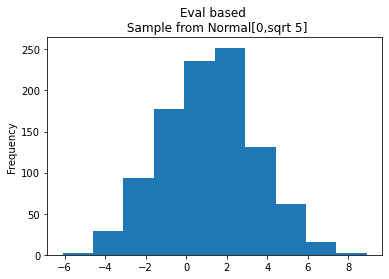

In [230]:

samples=[]
num_samples=1000
for _ in range(num_samples):
    samples.append(next(get_stream(graph)))


samples = pd.Series(samples)
samples.plot.hist()
plt.title('Graph based sampling \n Sample from Normal[0,sqrt 5]')

# `2.daphne` Bayes linear regression
`slope` $\sim \mathcal{N}[\mu=0,\sigma=10]$

`bias` $\sim \mathcal{N}[\mu=0,\sigma=10]$

In [208]:
graph = load_graph(i=2)
graph

[{'observe-data': ['fn',
   ['_', 'data', 'slope', 'bias'],
   ['let',
    ['xn', ['first', 'data']],
    ['let',
     ['yn', ['second', 'data']],
     ['let',
      ['zn', ['+', ['*', 'slope', 'xn'], 'bias']],
      ['let',
       ['dontcare9', ['observe', ['normal', 'zn', 1.0], 'yn']],
       ['rest', ['rest', 'data']]]]]]]},
 {'V': ['observe3',
   'observe6',
   'observe4',
   'observe7',
   'sample2',
   'sample1',
   'observe8',
   'observe5'],
  'A': {'sample2': ['observe3',
    'observe6',
    'observe4',
    'observe7',
    'observe8',
    'observe5'],
   'sample1': ['observe3',
    'observe6',
    'observe4',
    'observe7',
    'observe8',
    'observe5']},
  'P': {'sample1': ['sample*', ['normal', 0.0, 10.0]],
   'sample2': ['sample*', ['normal', 0.0, 10.0]],
   'observe3': ['observe*',
    ['normal', ['+', ['*', 'sample1', 1.0], 'sample2'], 1.0],
    2.1],
   'observe4': ['observe*',
    ['normal', ['+', ['*', 'sample1', 2.0], 'sample2'], 1.0],
    3.9],
   'observe5': ['ob

In [209]:
samples=[]
num_samples=1000
for _ in range(num_samples):
    samples.append(sample_from_joint(graph).tolist())


Text(0.5, 0.98, 'Evaluation based sampling \n Bayes linear regression')

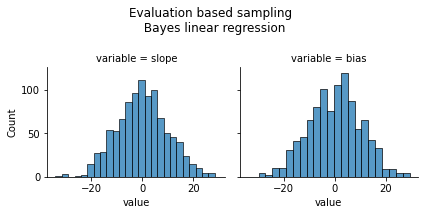

In [213]:
df = pd.DataFrame(samples)
df = pd.melt(df)
df['variable'] = df['variable'].map({0:'slope',1:'bias'})
g = sns.FacetGrid(df, col="variable")
g.map(sns.histplot, "value")

plt.subplots_adjust(top=0.7)
plt.suptitle('Graph based sampling \n Bayes linear regression')


# 3.daphne HMM
return is vector of length 17

In [214]:
graph = load_graph(i=3)
graph

[{'hmm-step': ['fn',
   ['t', 'states', 'data', 'trans-dists', 'likes'],
   ['let',
    ['z', ['sample', ['get', 'trans-dists', ['last', 'states']]]],
    ['let',
     ['dontcare33', ['observe', ['get', 'likes', 'z'], ['get', 'data', 't']]],
     ['append', 'states', 'z']]]]},
 {'V': ['observe32',
   'sample29',
   'sample5',
   'sample27',
   'sample23',
   'sample0',
   'sample25',
   'observe18',
   'observe12',
   'observe24',
   'sample17',
   'sample7',
   'observe6',
   'sample9',
   'sample31',
   'sample15',
   'sample19',
   'observe4',
   'observe22',
   'observe14',
   'observe28',
   'observe2',
   'observe10',
   'sample13',
   'observe26',
   'sample1',
   'observe30',
   'observe8',
   'sample3',
   'sample21',
   'sample11',
   'observe16',
   'observe20'],
  'A': {'sample29': ['sample31', 'observe30'],
   'sample5': ['sample7', 'observe6'],
   'sample27': ['sample29', 'observe28'],
   'sample23': ['sample25', 'observe24'],
   'sample0': ['sample1'],
   'sample25': ['s

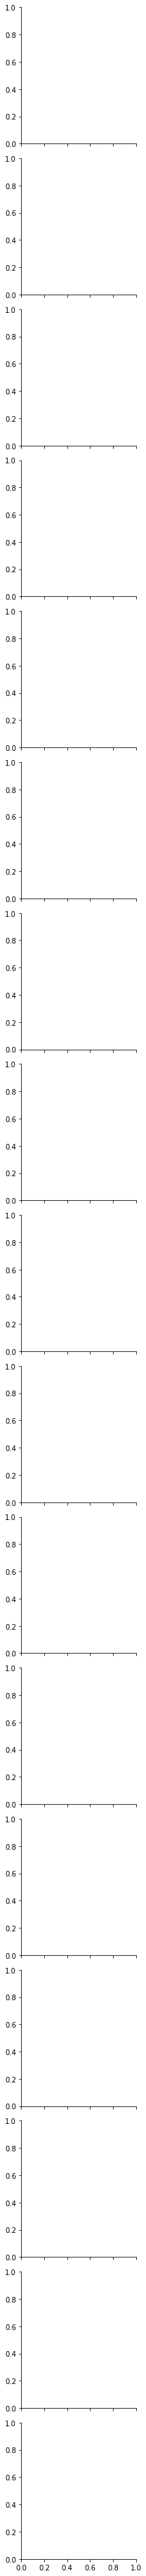

In [216]:
samples=[]
num_samples=1000
for _ in range(num_samples):
    samples.append(sample_from_joint(graph).tolist())
df = pd.melt(pd.DataFrame(samples))


Text(0.5, 0.98, 'Evaluation based sampling \n HMM')

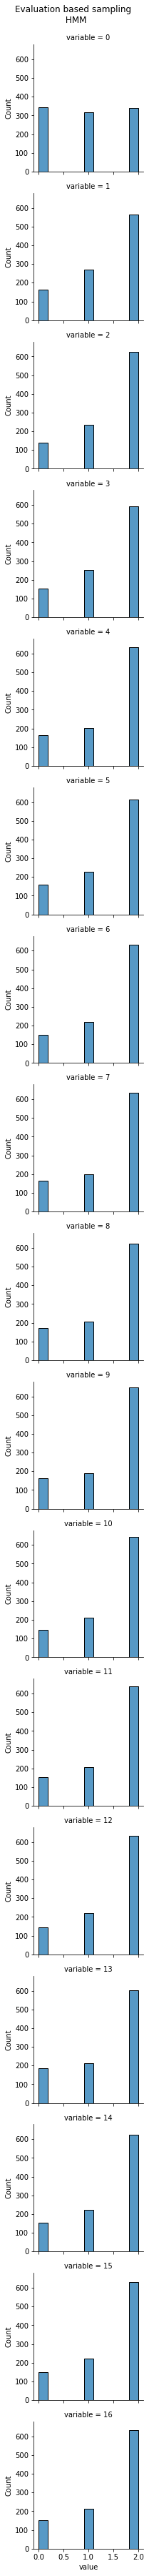

In [226]:
g = sns.FacetGrid(df, row="variable")
g.map(sns.histplot, "value")

plt.subplots_adjust(top=.965)
plt.suptitle('Graph based sampling \n HMM')

# `4.daphne`: Bayes NN
return is list of [W_0, b_0, W_1, b_1] with shapes (10),(10),(10,10),(10)

I flattened $W{1}$ so that $W{1}_{ij}$ is labelled `W_1_{i x j}`

In [231]:
graph = load_graph(i=4)
graph

[{},
 {'V': ['sample10',
   'sample111',
   'sample48',
   'sample92',
   'sample56',
   'sample95',
   'sample66',
   'sample127',
   'sample58',
   'sample136',
   'sample86',
   'sample119',
   'sample133',
   'sample34',
   'sample29',
   'sample138',
   'sample65',
   'sample24',
   'sample93',
   'sample126',
   'sample12',
   'sample53',
   'sample57',
   'sample129',
   'sample46',
   'sample64',
   'sample52',
   'sample5',
   'sample116',
   'sample88',
   'sample27',
   'sample117',
   'observe144',
   'sample28',
   'sample83',
   'sample96',
   'sample23',
   'sample98',
   'sample25',
   'sample109',
   'sample107',
   'sample131',
   'sample17',
   'observe143',
   'sample115',
   'sample61',
   'sample101',
   'sample132',
   'sample54',
   'sample7',
   'sample39',
   'sample72',
   'sample51',
   'sample8',
   'sample87',
   'sample55',
   'observe142',
   'sample102',
   'sample121',
   'sample9',
   'sample104',
   'sample73',
   'sample18',
   'sample31',
   'sampl

In [232]:
label_stem_li = []
values_li = []
variables_li = []

def parse_helper(arr,label_stem):
    arr = np.array(arr).flatten()
    labels = [label_stem+str(i) for i in range(arr.size)]
    return arr, labels

num_samples=1000
for _ in range(num_samples):
    W_0, b_0, W_1, b_1 = sample_from_joint(graph)
    for arr_not_flattened, label_stem in zip([W_0, b_0, W_1, b_1],['W_0','b_0','W_1','b_1']):
        arr, labels = parse_helper(arr_not_flattened,label_stem+'_')
        label_stem_li.extend([label_stem]*arr.size)
        values_li.extend(arr.tolist())
        variables_li.extend(labels)

In [233]:
df = pd.DataFrame({'value':values_li,'variable':variables_li,'return_object':label_stem_li})
df.sample(10)

,value,variable,return_object
86676,-0.074984,W_1_76,W_1
80022,0.781605,W_1_52,W_1
34933,0.229218,W_1_73,W_1
61955,0.372719,W_1_55,W_1
100396,-0.530175,W_1_16,W_1
5206,0.305943,W_0_6,W_0
11520,0.752261,W_1_60,W_1
114560,0.657682,W_1_10,W_1
6515,1.410540,b_0_5,b_0
32878,-1.331255,W_1_98,W_1


In [ ]:
plt.subplots_adjust(top=.965)
plt.suptitle('Graph based sampling \n Bayes NN')

g = sns.FacetGrid(df, row="variable")
g.map(sns.histplot, "value")